In [1]:
import pandas as pd
from ggplot import *
import numpy as np

project_id = "the-d-team-164512"

In [31]:
df_pharma_compass = pd.read_csv('../small_data/pharma_compass_patent_expiry.csv',
                               parse_dates=['Patent Expiration'])
df_pharma_compass['drug'] = df_pharma_compass['Product']
df_pharma_compass['drug'] = df_pharma_compass['drug'].apply(lambda x: str(x).upper())
df_pharma_compass['expiry'] = df_pharma_compass['Patent Expiration']

df_drugs_com = pd.read_csv('../small_data/drugs_com_patent_expiration.csv')
df_drugs_com['drug'] = df_drugs_com['drug'].apply(lambda x: x.upper())
df_drugs_com['expiry'] = df_drugs_com['expiry year']\
    .apply(lambda x: ('%d-12-31' % x))\
    .apply(pd.to_datetime, format='%Y-%m-%d')

df_new_drug_approvals = pd.read_csv('../small_data/new_drug_approvals_patent_expiry.csv',
                                    parse_dates=['expiry year'])
df_new_drug_approvals['drug'] = df_new_drug_approvals['drug'].apply(lambda x: x.upper())
df_new_drug_approvals['expiry'] = df_new_drug_approvals['expiry year']

df_patent_expiries = pd.DataFrame(df_new_drug_approvals[['expiry', 'drug']])
df_patent_expiries = pd.concat([df_patent_expiries, df_drugs_com[['expiry', 'drug']]])
df_patent_expiries = pd.concat([df_patent_expiries, df_pharma_compass[['expiry', 'drug']]])
df_patent_expiries.head(3)

df_drug_lookup = pd.read_csv('../../MelbDatathon2017/Lookups/Drug_LookUp.txt', sep="\t")
df_drug_lookup['drug'] = df_drug_lookup['BrandName']
df_drug_lookup

df = pd.merge(df_patent_expiries, df_drug_lookup, on='drug', how='inner')

for drug in list(set(df_patent_expiries.drug) - set(df.drug.unique())):
    first_drug_word = drug.split()[0].split(';')[0]
    if first_drug_word == None:
        first_drug_word = drug
    found = df_drug_lookup.drug.str.contains(first_drug_word)
    found = df_drug_lookup[df_drug_lookup.drug.str.contains(drug)]
    if len(found) > 0:
        df = df.append(found, ignore_index=True)
    else:
        found = df_drug_lookup[df_drug_lookup.MasterProductFullName.str.contains(first_drug_word)]
        found.drug = found.drug.apply(lambda x: drug)
        if len(found) > 0:
            df = df.append(found, ignore_index=True)
        else:
            found = df_drug_lookup[df_drug_lookup.GenericIngredientName.str.contains(first_drug_word)]
            found.drug = found.drug.apply(lambda x: drug)
            if len(found) > 0:
                df = df.append(found, ignore_index=True)

print("\n\nDrug IDs found")
print(len(df.drug.unique()))

print("\n\nIncluding drugs:")
print(df.drug.unique()[0 : 10])

print("\n\nNot Including drugs:")
print(list(set(df_patent_expiries.drug) - set(df.drug.unique()))[0 : 10])

print("\n\nDrug IDs NOT found")
print(len(list(set(df_patent_expiries.drug) - set(df.drug.unique()))))

# df[df.GenericIngredientName == 'AMLODIPINE'] # check a particular drug

/opt/boxen/homebrew/lib/python3.5/site-packages/pandas/core/generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value




Drug IDs found
221


Including drugs:
['LIPITOR' 'ZYPREXA' 'CONCERTA' 'PLAVIX' 'SEROQUEL' 'SINGULAIR' 'ACTOS'
 'ENBREL' 'RIZATRIPTAN' 'NEXIUM']


Not Including drugs:
['ASACOL', 'VIANI', 'NITRIC OXIDE', 'TRETINOIN', 'SEROPLEX', 'MYSLEE', 'PITAVASTATIN', 'PALVIZUMAB', 'TELMISARTAN', 'TELMISTRAN']


Drug IDs NOT found
85


In [32]:
df.MasterProductID.unique()

query = """\
SELECT
  d.BrandName AS brand_name
  , DATE(t.Dispense_Week) AS date
  , COUNT(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions_all_c] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
WHERE t.Drug_ID IN ({0})
GROUP BY
  brand_name
  , date
ORDER BY
  brand_name
  , date ASC
"""

drug_ids = ",".join(np.char.mod('%d', df.MasterProductID.unique()))
query = query.format(drug_ids)
df_patent = pd.read_gbq(query, project_id)
df_patent.date = pd.Series(df_patent.date).apply(pd.to_datetime, format='%Y-%m-%d')

df_patent.head(3)

Waiting for job to complete...
Waiting for job to complete...


,brand_name,date,transaction_count
0,ABILIFY,2010-12-26,3
1,ABILIFY,2011-01-02,145
2,ABILIFY,2011-01-09,105


Lots of drop offs presumably around the drugs going off patent.

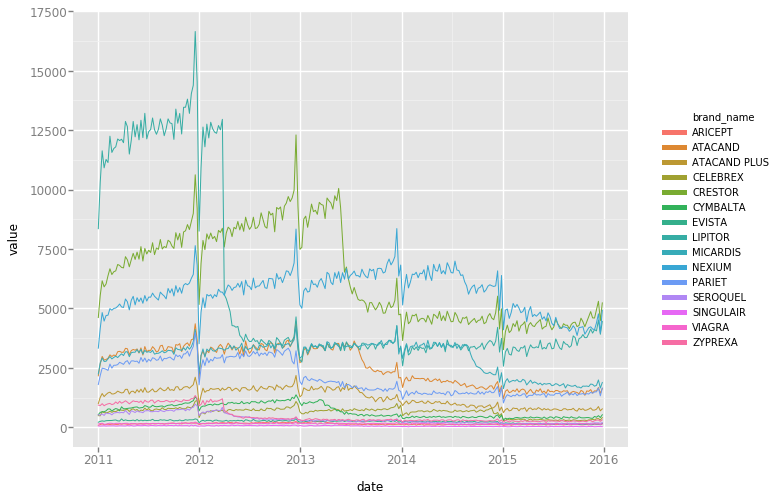

<ggplot: (286355520)>

In [40]:
drug_drop_off = ['LIPITOR', 'ZYPREXA', 'SEROQUEL', 'SINGULAIR', 'VIAGRA', 'ARICEPT',
                 'PARIET', 'ATACAND', 'ATACAND PLUS', 'MICARDIS', 'NEXIUM', 'CYMBALTA',
                 'CELEBREX', 'EVISTA', 'CRESTOR']
drug_slow_off = ['PLAVIX', 'ACTOS', 'OXYCONTIN', 'COPAXONE', 'TRITACE', 'PROPECIA',
                 'PROSCAR', 'TOPAMAX']
# some missing but have likely generics
# 'TRITACE' is patent version of 'RAMIPRIL'
# 'TOPAMAX' is patent version of 'TOPIRAMATE'
# 'NEXIUM' 'ESOMEPRAZOLE'
# MERCADIS is 'TELMISARTAN'
# PROPECIA or PROSCAR is 'FINASTERIDE'

df_patent_lng = pd.melt(df_patent[
    (df_patent.date >= '2011-01-01') &\
    (df_patent.date < '2016-01-01') &\
    (df_patent.brand_name.isin(drug_drop_off))],
    id_vars=['date', 'brand_name'])
ggplot(
    aes(x='date', y='value', colour='brand_name'),
    data=df_patent_lng) +\
    geom_line()


Clear drop offs

       expiry     drug
0  2011-12-31  LIPITOR
15 2012-12-31  LIPITOR


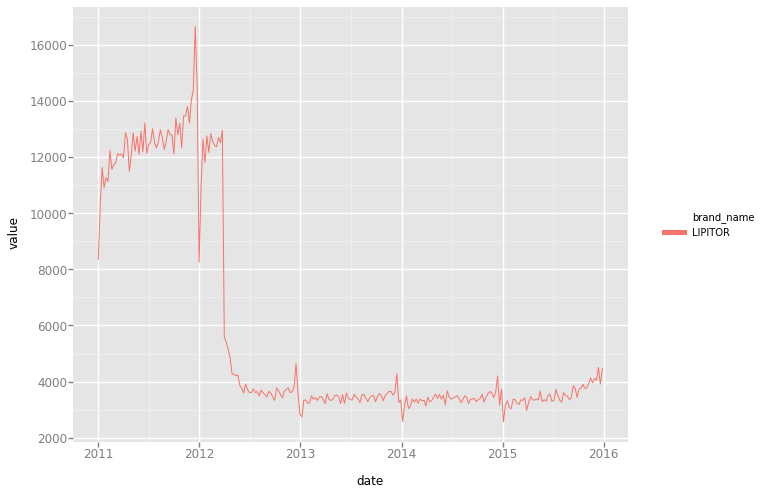

<ggplot: (286305470)>
       expiry     drug
1  2011-12-31  ZYPREXA
83 2015-12-31  ZYPREXA


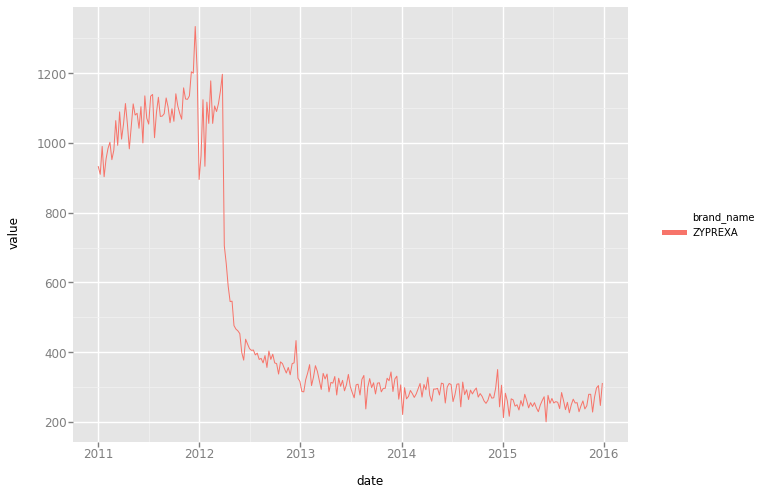

<ggplot: (291430485)>
       expiry      drug
6  2012-12-31  SEROQUEL
1  2012-12-31  SEROQUEL
14 2012-12-31  SEROQUEL
17 2012-12-31  SEROQUEL
25 2012-12-31  SEROQUEL


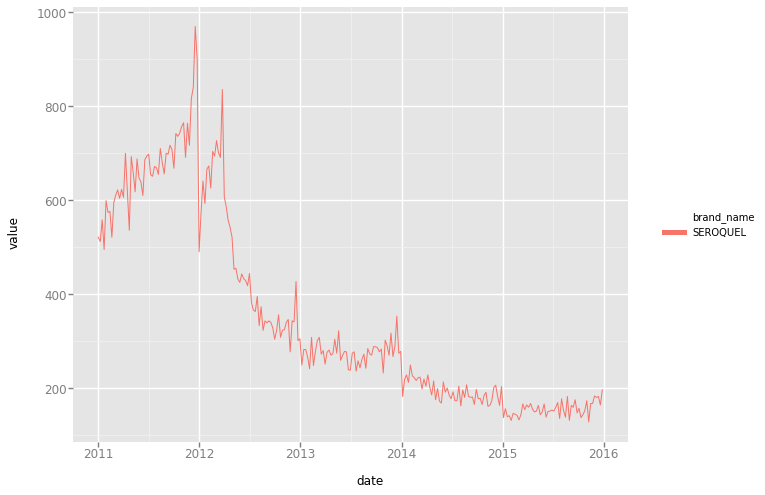

<ggplot: (289618622)>
       expiry       drug
7  2012-12-31  SINGULAIR
2  2012-12-31  SINGULAIR
19 2012-12-31  SINGULAIR
21 2012-12-31  SINGULAIR


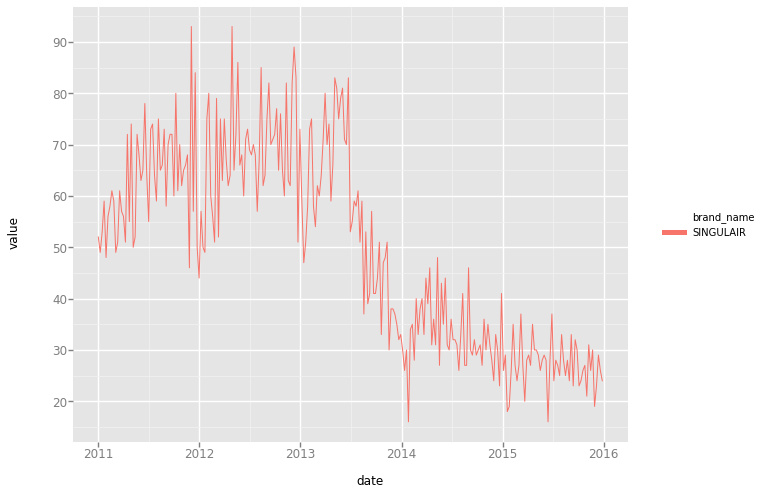

<ggplot: (-9223372036563836942)>
       expiry    drug
8  2012-12-31  VIAGRA
40 2013-12-31  VIAGRA
46 2013-12-31  VIAGRA
51 2013-12-31  VIAGRA


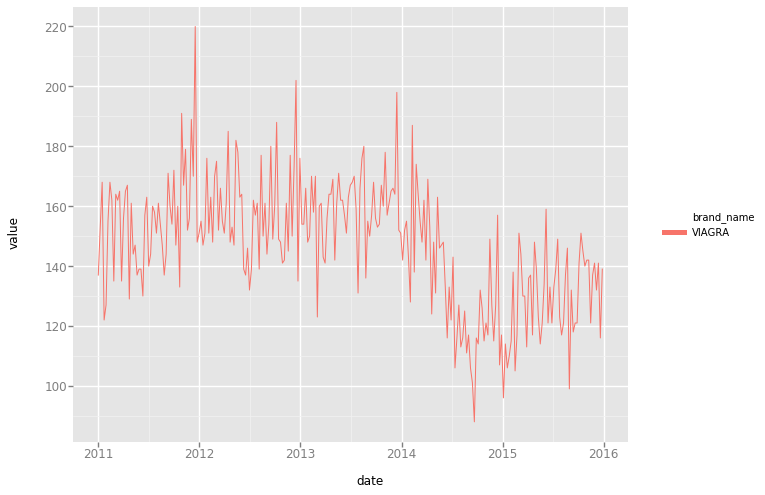

<ggplot: (-9223372036563091810)>
       expiry     drug
18 2012-12-31  ARICEPT
29 2012-12-31  ARICEPT


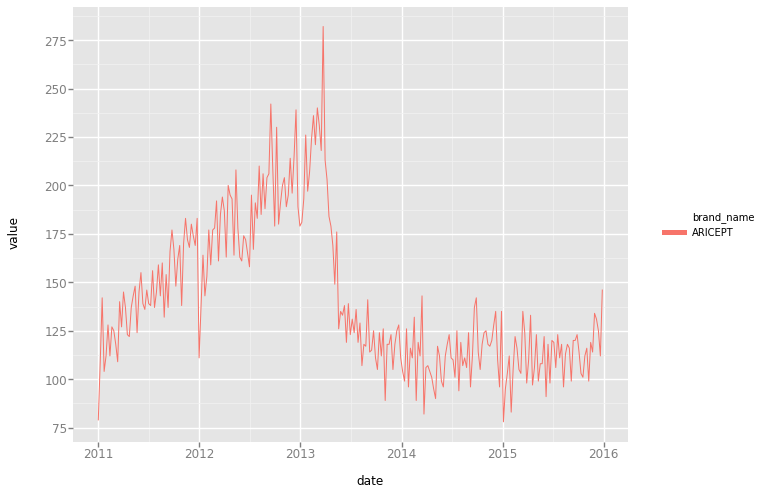

<ggplot: (291484508)>
       expiry    drug
22 2012-12-31  PARIET


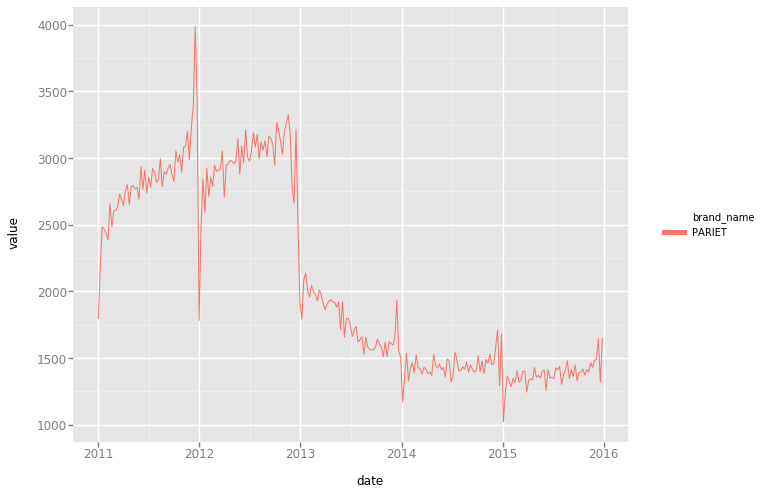

<ggplot: (-9223372036562654120)>
       expiry     drug
26 2012-12-31  ATACAND


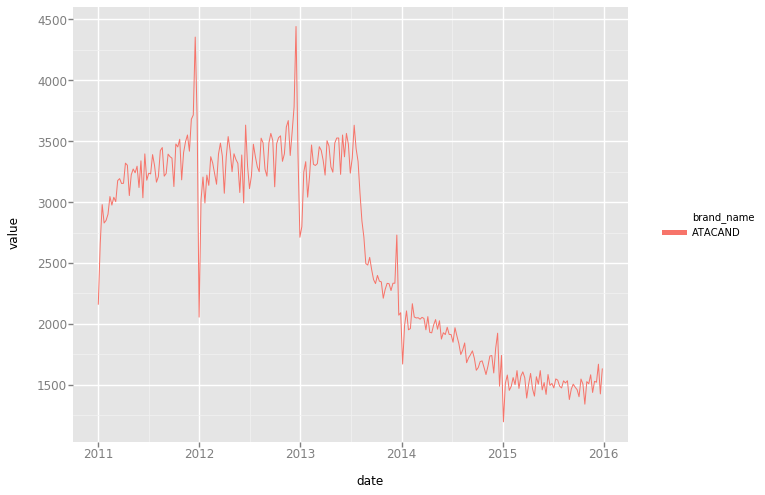

<ggplot: (291229476)>
       expiry          drug
27 2012-12-31  ATACAND PLUS


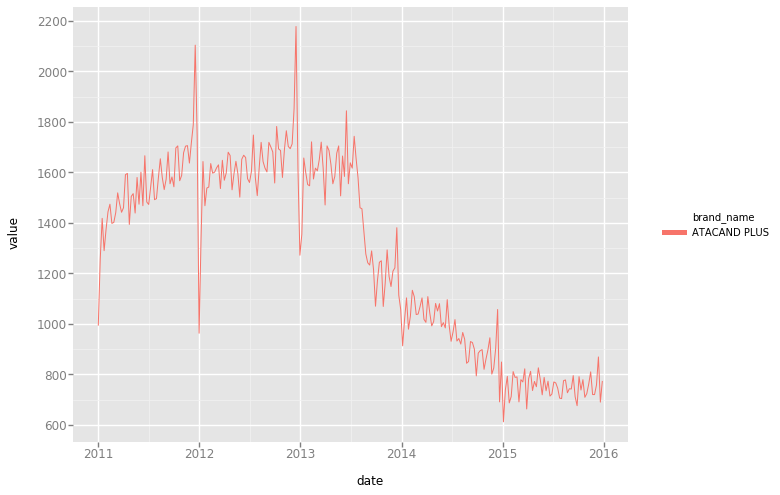

<ggplot: (292042728)>
       expiry      drug
45 2013-12-31  MICARDIS


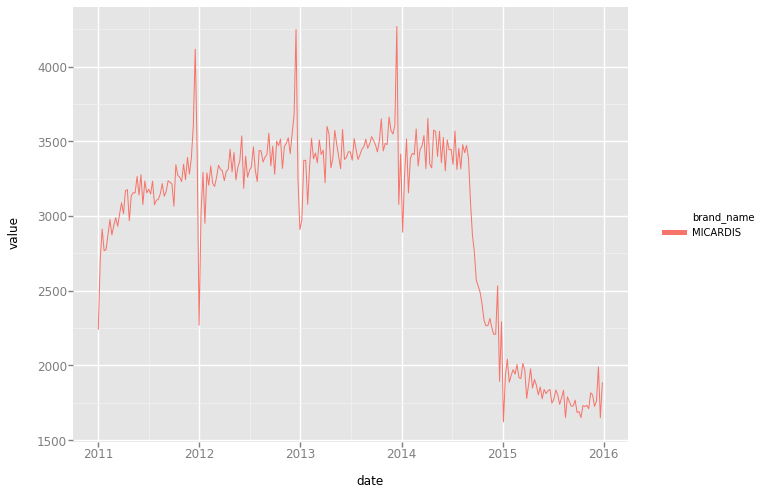

<ggplot: (291550903)>
       expiry    drug
30 2014-05-01  NEXIUM
52 2014-12-31  NEXIUM


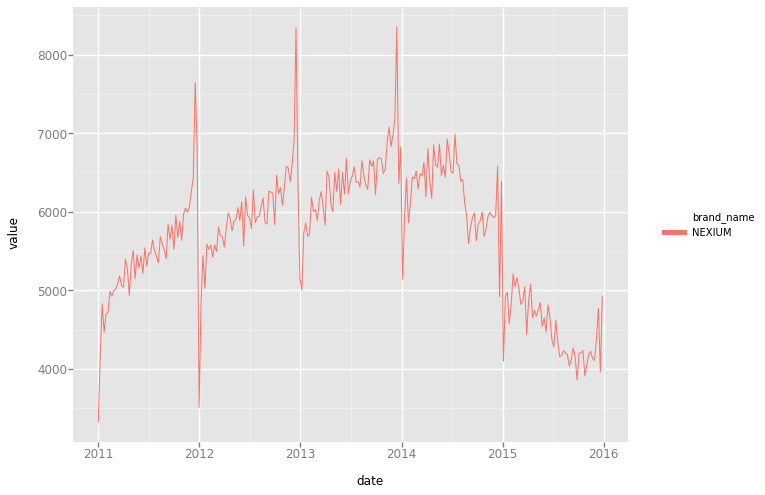

<ggplot: (-9223372036563887237)>
       expiry      drug
53 2014-12-31  CYMBALTA
89 2015-12-31  CYMBALTA
95 2015-12-31  CYMBALTA
99 2015-12-31  CYMBALTA


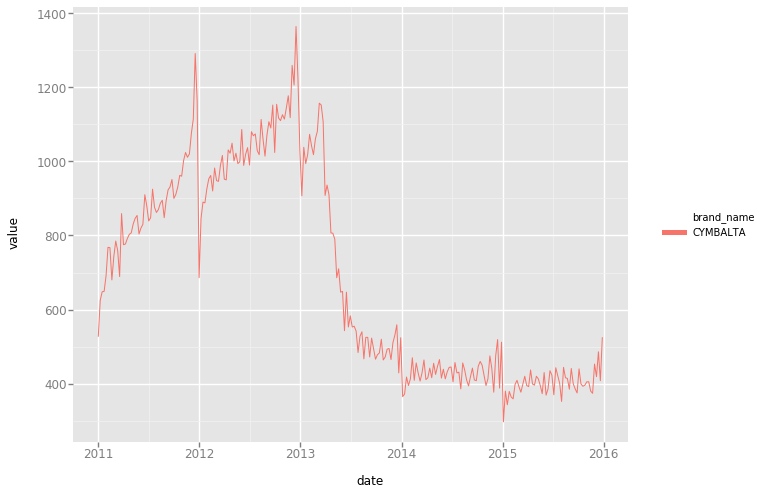

<ggplot: (291430902)>
       expiry      drug
54 2014-12-31  CELEBREX


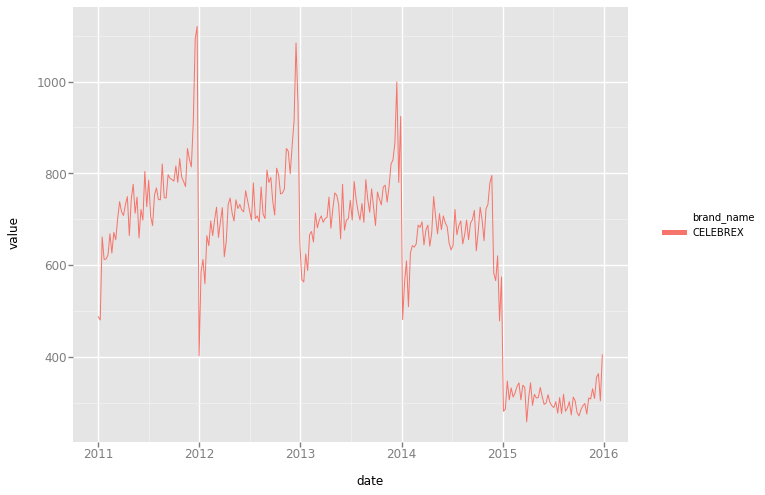

<ggplot: (288717779)>
       expiry    drug
58 2014-12-31  EVISTA


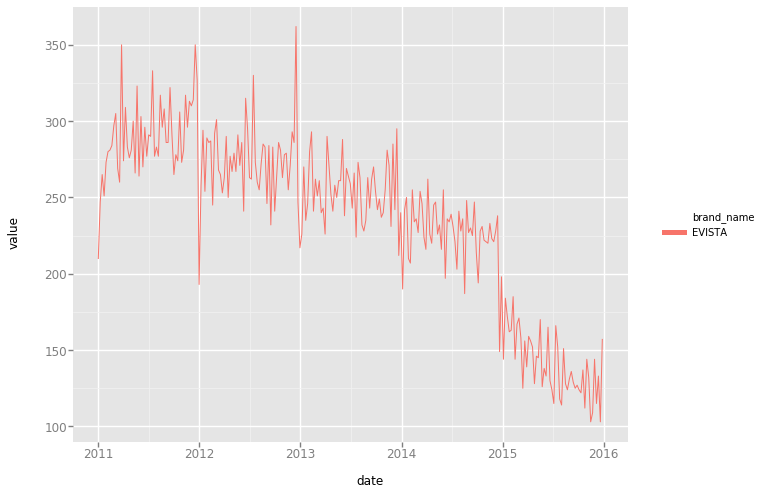

<ggplot: (-9223372036559971268)>
        expiry     drug
100 2016-12-31  CRESTOR


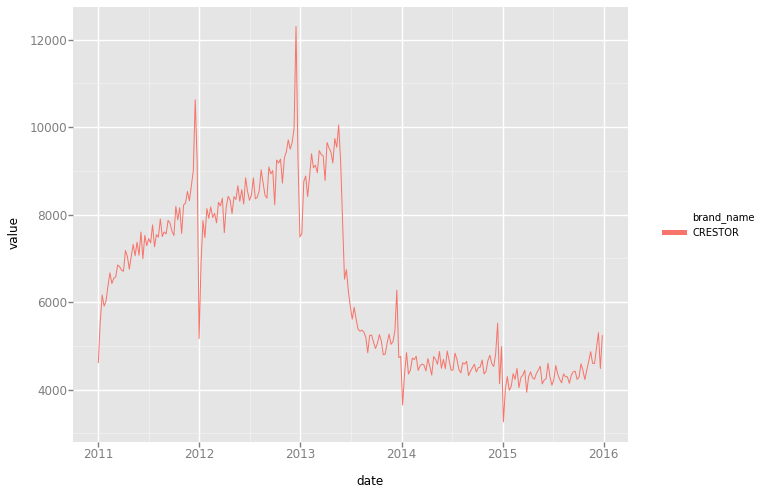

<ggplot: (284883797)>


In [41]:
def show_dropoff(drug_name):
    some_drugs = [drug_name]
    df_patent_lng = pd.melt(df_patent[
        (df_patent.date >= '2011-01-01') &\
        (df_patent.date < '2016-01-01') &\
        (df_patent.brand_name.isin(some_drugs))],
                            id_vars=['date', 'brand_name'])

    print(df_patent_expiries[df_patent_expiries.drug.isin(some_drugs)])

    print(ggplot(
        aes(x='date', y='value', colour='brand_name'),
        data=df_patent_lng) +\
        geom_line())

for drug_name in drug_drop_off:
    show_dropoff(drug_name)

Slow loss of popularity

       expiry    drug
5  2012-12-31  PLAVIX
0  2012-12-31  PLAVIX
37 2013-12-31  PLAVIX


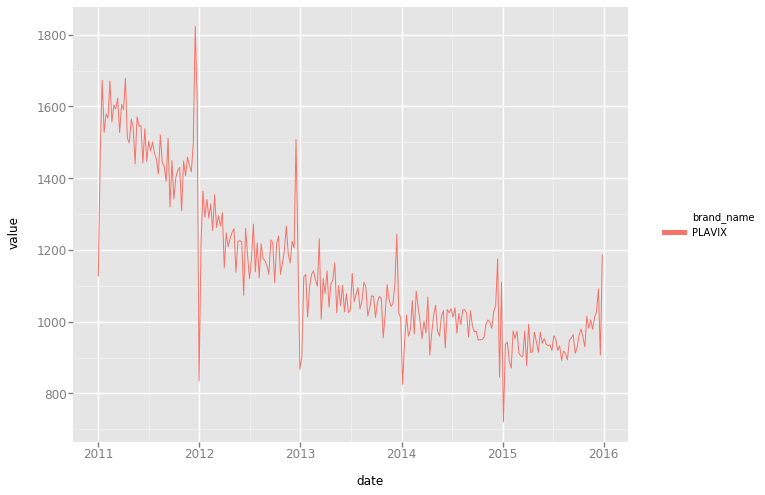

<ggplot: (-9223372036561842130)>
      expiry   drug
8 2012-12-31  ACTOS
3 2012-12-31  ACTOS


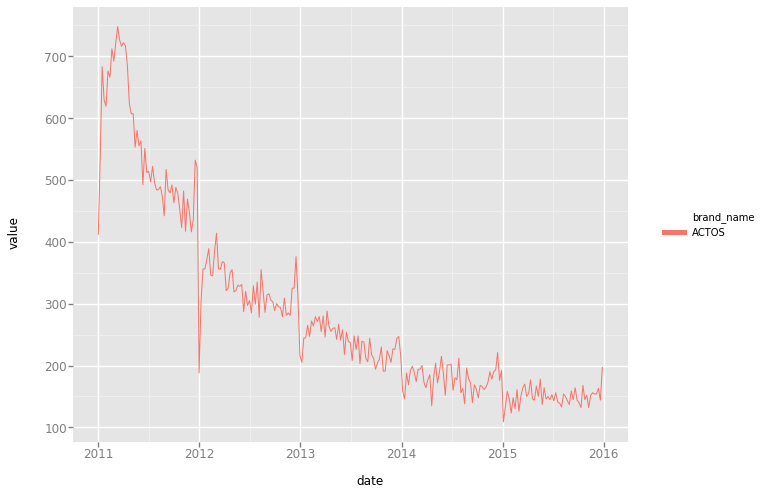

<ggplot: (287346538)>
       expiry       drug
30 2013-12-31  OXYCONTIN


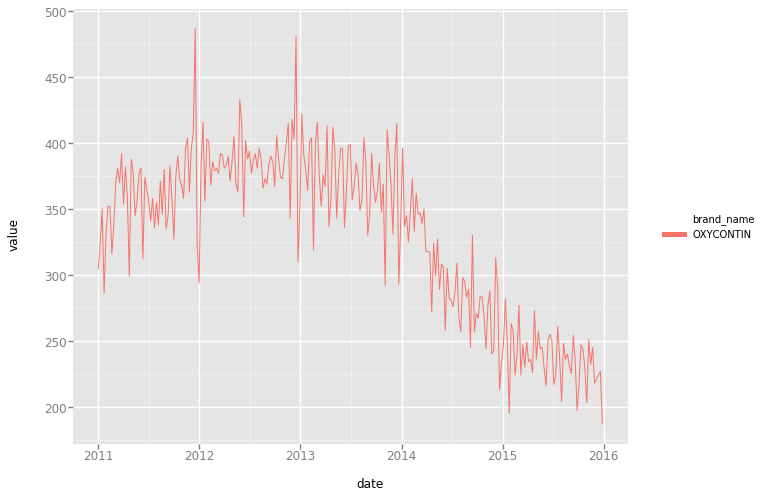

<ggplot: (-9223372036567415671)>
       expiry      drug
75 2015-12-31  COPAXONE
93 2015-12-31  COPAXONE
97 2015-12-31  COPAXONE


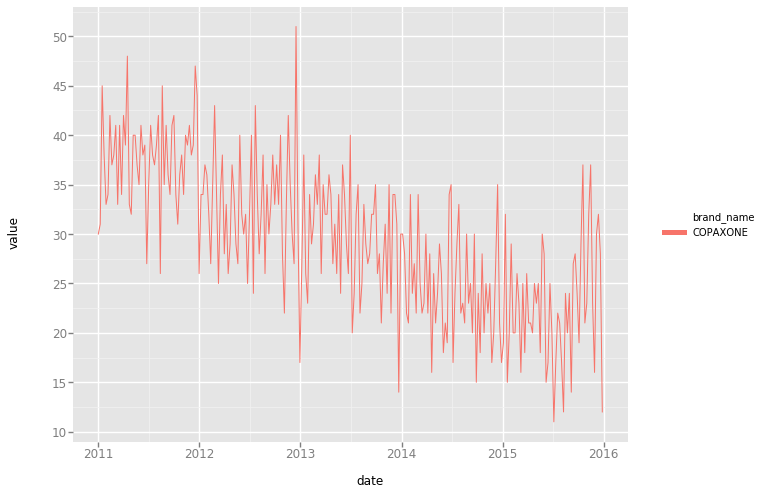

<ggplot: (-9223372036564971239)>
        expiry     drug
138 2020-08-30  TRITACE


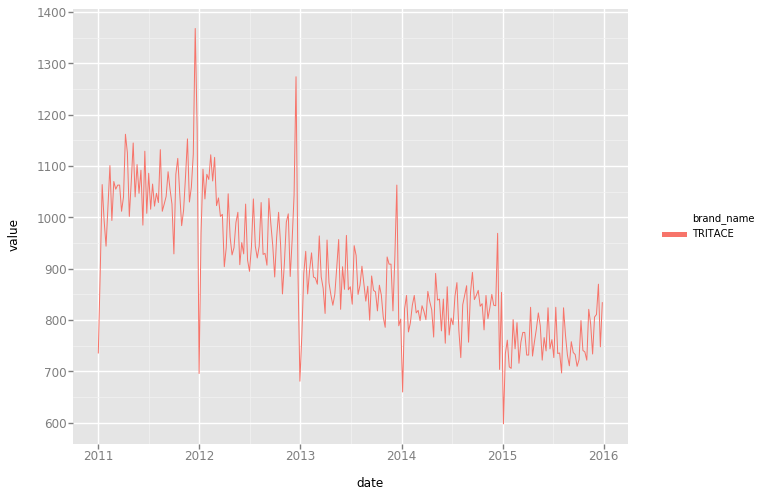

<ggplot: (-9223372036563989679)>
        expiry      drug
153 2018-10-23  PROPECIA


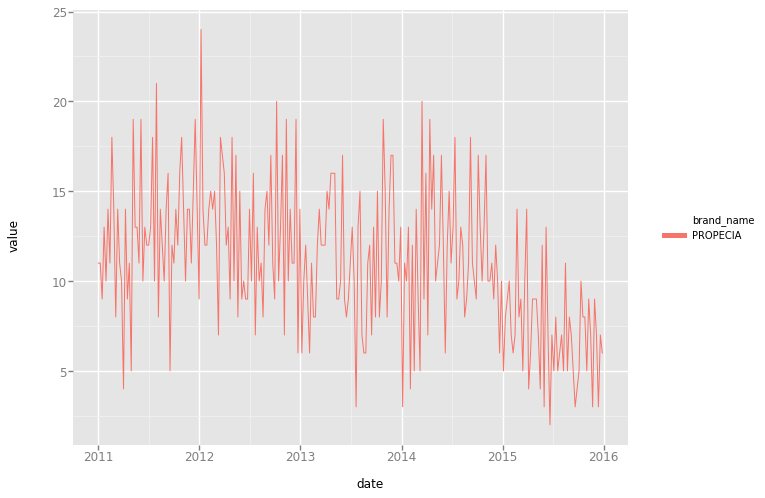

<ggplot: (291206632)>
        expiry     drug
154 2018-10-23  PROSCAR


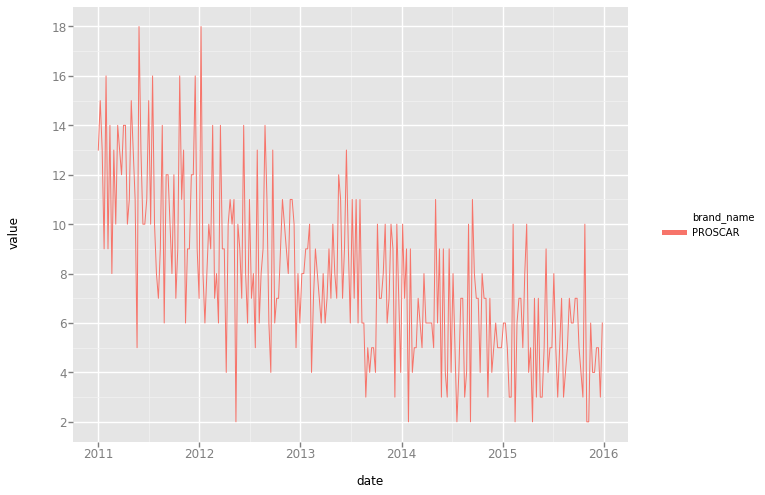

<ggplot: (-9223372036569890907)>
        expiry     drug
294 2019-03-01  TOPAMAX


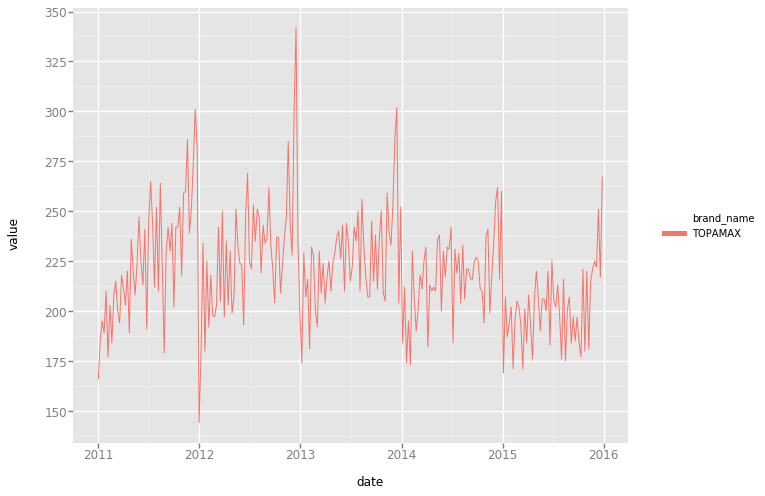

<ggplot: (-9223372036566603071)>


In [42]:
for drug_name in drug_slow_off:
    show_dropoff(drug_name)